In [1]:
from __future__ import print_function

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Lambda, Input
from keras import backend as K
import keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
from sklearn.model_selection import train_test_split

/mnt/Data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Pretrain a small arch on mnist

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 50
num_classes = 10
epochs = 2

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [4]:
[(l.name, l.output_shape) for l in model.layers]

[('conv2d_1', (None, 26, 26, 32)),
 ('conv2d_2', (None, 24, 24, 64)),
 ('max_pooling2d_1', (None, 12, 12, 64)),
 ('dropout_1', (None, 12, 12, 64)),
 ('flatten_1', (None, 9216)),
 ('dense_1', (None, 128)),
 ('dropout_2', (None, 128)),
 ('dense_2', (None, 10))]

In [5]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/2
60000/60000 [==============================] - 23s 385us/step - loss: 0.2094 - acc: 0.9366
Epoch 2/2
60000/60000 [==============================] - 22s 363us/step - loss: 0.0875 - acc: 0.9739
Test loss: 0.03607443962517427
Test accuracy: 0.9876


# Re-train final layers

acctually it was better not to freeze anay layers from the previous training. Maybe it still helps as an initialization point?

((200, 28, 28, 1), (200, 1))

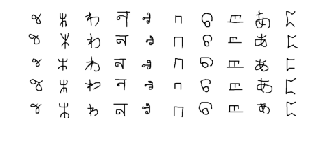

In [11]:
def gen_omniglot(N = 2, n_samples_print=5):
    features = np.load('./Data/omniglot_inceptionV3_features.npy')
    n_classes, n_samples, n_features = features.shape
    classes = np.random.choice(np.arange(features.shape[0]), size=N, replace=False)
    images = np.load('./Data/omniglot.npy')
    n_classes, n_samples, n_pixels = images.shape
    imgs = np.reshape(images[classes, :, :], (N,n_samples, 28, 28))
    plt.figure(figsize=(N//2, 2))
    for i in range (N):
        for j in range(n_samples_print):
            plt.subplot2grid((n_samples_print, N), (j, i))
            img = imgs[i, j, ... ].squeeze()
            plt.imshow(img, cmap='Greys_r')
            plt.axis('off')
    X = np.reshape(images[classes, :, :], (N*n_samples, 28, 28, 1))
    y = np.repeat(np.arange(N), n_samples).reshape(N*n_samples, 1)
    return X, y
# sample a subset of omniglot
N=10
np.random.seed(0)
X, y = gen_omniglot(N=N)
X.shape, y.shape

In [12]:
# separate validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=5*N, stratify=y)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2022: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
preds = Dense(N, activation='softmax', use_bias=False)(model.layers[-2].output)
new_model = Model(model.input, preds)

In [14]:
# freeze first layers
# for layer in new_model.layers[0:2]:
#     layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optmizer = keras.optimizers.Adam(lr=0.0001)
new_model.compile(optimizer=optmizer, loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model on the new data for a few epochs
new_model.fit(X_train, keras.utils.to_categorical(y_train, N), 
          batch_size=50, epochs=50, verbose=2, shuffle=True,
          validation_data=(X_val, keras.utils.to_categorical(y_val, N)))

Train on 50 samples, validate on 150 samples
Epoch 1/50
 - 1s - loss: 1.1724 - acc: 0.7000 - val_loss: 1.2997 - val_acc: 0.6800
Epoch 2/50
 - 0s - loss: 1.1546 - acc: 0.6400 - val_loss: 1.2901 - val_acc: 0.6867
Epoch 3/50
 - 0s - loss: 1.2167 - acc: 0.7400 - val_loss: 1.2802 - val_acc: 0.6867
Epoch 4/50
 - 0s - loss: 1.1954 - acc: 0.6600 - val_loss: 1.2706 - val_acc: 0.7067
Epoch 5/50
 - 0s - loss: 1.2193 - acc: 0.5800 - val_loss: 1.2607 - val_acc: 0.7067
Epoch 6/50
 - 0s - loss: 1.1418 - acc: 0.6600 - val_loss: 1.2504 - val_acc: 0.7067
Epoch 7/50
 - 0s - loss: 1.2000 - acc: 0.6200 - val_loss: 1.2402 - val_acc: 0.7067
Epoch 8/50
 - 0s - loss: 0.9011 - acc: 0.8000 - val_loss: 1.2298 - val_acc: 0.7067
Epoch 9/50
 - 0s - loss: 0.9014 - acc: 0.7600 - val_loss: 1.2194 - val_acc: 0.7067
Epoch 10/50
 - 0s - loss: 1.0257 - acc: 0.7200 - val_loss: 1.2092 - val_acc: 0.7067
Epoch 11/50
 - 0s - loss: 1.0909 - acc: 0.6800 - val_loss: 1.1992 - val_acc: 0.7067
Epoch 12/50
 - 0s - loss: 0.8972 - acc: 

# Small arch directly on omniglot

In [15]:
dmodel = Sequential()
dmodel.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
dmodel.add(Conv2D(64, (3, 3), activation='relu'))
dmodel.add(MaxPooling2D(pool_size=(2, 2)))
dmodel.add(Dropout(0.25))
dmodel.add(Flatten())
dmodel.add(Dense(128, activation='relu'))
dmodel.add(Dropout(0.5))
dmodel.add(Dense(N, activation='softmax'))

dmodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
dmodel.fit(X_train, keras.utils.to_categorical(y_train, N), 
          batch_size=50, epochs=50, verbose=2, shuffle=True,
          validation_data=(X_val, keras.utils.to_categorical(y_val, N)))

Train on 50 samples, validate on 150 samples
Epoch 1/50
 - 1s - loss: 2.3497 - acc: 0.1200 - val_loss: 2.2948 - val_acc: 0.1000
Epoch 2/50
 - 0s - loss: 2.2829 - acc: 0.1600 - val_loss: 2.2576 - val_acc: 0.1733
Epoch 3/50
 - 0s - loss: 2.2734 - acc: 0.1600 - val_loss: 2.2300 - val_acc: 0.1800
Epoch 4/50
 - 0s - loss: 2.2708 - acc: 0.1800 - val_loss: 2.1845 - val_acc: 0.4467
Epoch 5/50
 - 0s - loss: 2.2076 - acc: 0.1600 - val_loss: 2.1368 - val_acc: 0.5067
Epoch 6/50
 - 0s - loss: 2.0046 - acc: 0.4000 - val_loss: 2.0915 - val_acc: 0.5867
Epoch 7/50
 - 0s - loss: 1.9847 - acc: 0.3600 - val_loss: 2.0448 - val_acc: 0.6133
Epoch 8/50
 - 0s - loss: 1.9222 - acc: 0.5200 - val_loss: 1.9892 - val_acc: 0.6000
Epoch 9/50
 - 0s - loss: 1.7630 - acc: 0.6800 - val_loss: 1.9207 - val_acc: 0.6133
Epoch 10/50
 - 0s - loss: 1.6304 - acc: 0.7000 - val_loss: 1.8469 - val_acc: 0.6333
Epoch 11/50
 - 0s - loss: 1.5017 - acc: 0.7200 - val_loss: 1.7701 - val_acc: 0.6467
Epoch 12/50
 - 0s - loss: 1.3644 - acc: 